In [1]:
import os
import glob
import gzip
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

import shapely.wkt as wkt
from shapely.geometry import Point, LineString, box
from shapely.ops import nearest_points
import lxml.etree as ET
import network_io as nio
from itertools import combinations
import random

import re


## 1. Check which combinations we have already computed

In [2]:
is_for_1pm = True
result_df_name = 'dataset_1pm_0-5000'

result_path = '../../../../data/datasets_simulation_outputs/' + result_df_name + '.pt'
string_is_for_1pm = "pop_1pm" if is_for_1pm else "pop_1pct"

base_dir = '../../../../data/' + string_is_for_1pm + '_simulations/' + string_is_for_1pm + '_with_policies/'
subdirs_pattern = os.path.join(base_dir, 'output_networks_*')
subdirs = list(set(glob.glob(subdirs_pattern)))
subdirs.sort()

combinations_already_computed = []

def extract_numbers_from_string(network_string):
    # Use regular expression to find all numbers in the string
    numbers = re.findall(r'\d+', network_string)
    
    # Convert the list of strings to a set of integers
    number_set = set(map(int, numbers))
    
    return number_set

# Loop through each subdirectory
for subdir in subdirs:
    if "filtered" in subdir:
        continue
    print(f'Accessing folder: {subdir}')
    print(len(os.listdir(subdir)))
    networks = [network for network in os.listdir(subdir) if not network.endswith(".DS_Store")]
    print(len(networks))

    for network in networks:
        file_path = os.path.join(subdir, network)
        print(network)
        number_set = extract_numbers_from_string(network)
        combinations_already_computed.append(number_set)

Accessing folder: ../../../../data/pop_1pm_simulations/pop_1pm_with_policies/output_networks_100
101
100
network_d_2_4_6_8_9_11_12_13_14_16_17_18_19
network_d_1_2_3_4_7_10_11_12_15_16_17_19
network_d_1_2_4_7_8_9_10_14_15_17_18
network_d_1_2_3_4_5_6_9_12_13_14_18
network_d_1_3_6_8_11_17_18_19_20
network_d_1_2_5_6_8_11_12_13_14_15_16_17_18
network_d_1_3_4_5_6_7_8_9_10_12_13_14_17_19_20
network_d_1_2_4_5_8_11_14_16_20
network_d_4_5_6_7_8_11_12_13_15_16_17_18_19
network_d_1_5_6_7_8_9_11_15_17_18_19_20
network_d_4_6_7_9_10_11_12_13_14_17_18
network_d_1_2_3_6_7_10_14_19_20
network_d_5
network_d_3_4_5_8_10_11_13_14_17_18_20
network_d_3_4_5_6_7_8_11_13_14_16_17_18_19
network_d_2
network_d_3_5_6_7_8_9_10_11_12_13_14_16_17_18
network_d_2_4_5_6_10_13_15_16_19
network_d_1_2_4_7_8_9_10_11_12_13_15_17_18_20
network_d_1_2_3_4_5_6_7_9_10_12_13_14_15_17_18_19
network_d_1_2_4_6_7_8_9_11_13_14_16_18_20
network_d_1_2_4_5_8_9_11_12_13_14_15_16_17
network_d_2_4_5_6_7_9_11_14_19_20
network_d_3
network_d_4
ne

In [3]:
def check_sets_in_list(combination_already_computed, *sets_to_check):
    # Result dictionary to store whether each set is in the list
    results = {}
    for s in sets_to_check:
        # Check if the current set is in the list
        results[tuple(sorted(s))] = s in combination_already_computed
    return results

# Pass the sets you want to check as arguments
sets_to_check = [{1, 2, 3, 4}, {5, 6, 7}, {9, 10, 11}, {8, 9, 10}, {1}, {20}]
results = check_sets_in_list(combinations_already_computed, *sets_to_check)

# Print the results
for s, exists in results.items():
    print(f"Set {s} exists: {exists}")

Set (1, 2, 3, 4) exists: True
Set (5, 6, 7) exists: True
Set (9, 10, 11) exists: False
Set (8, 9, 10) exists: False
Set (1,) exists: True
Set (20,) exists: True


## Create subsets 

In [4]:
# import itertools

# # List of 20 districts (represented as integers 1 to 20, can be replaced with actual district names)
# districts = list(range(1, 21))

# # Find all combinations of districts with a maximum of 2 districts
# combinations = []
# for r in range(2, 7):  # r is the number of districts in the combination (1 or 2)
#     combinations.extend(itertools.combinations(districts, r))

# # If you want to know the total number of combinations:
# print(f"Total number of combinations: {len(combinations)}")

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt

# List of 20 districts (represented as integers 1 to 20)
districts = list(range(1, 21))

# Function to generate 50,000 unique subsets with sizes following a normal distribution
def generate_unique_subsets(districts, mean=4, std_dev=3, target_size=50000):
    unique_subsets = set()
    
    while len(unique_subsets) < target_size:
        # Generate a random subset size from a normal distribution, round to the nearest integer
        subset_size = max(1, int(np.random.normal(mean, std_dev)))
        
        # Ensure that subset size does not exceed the number of available districts
        subset_size = min(subset_size, len(districts))
        
        # Randomly sample districts for the subset
        subset = tuple(sorted(random.sample(districts, subset_size)))
        
        # Add the subset to the set of unique subsets
        unique_subsets.add(subset)
    
    return list(unique_subsets)

# Generate 80,000 unique subsets
new_combinations = generate_unique_subsets(districts, mean=5, std_dev=1, target_size=10000)

# Check the number of unique subsets
print(f"Number of unique subsets: {len(new_combinations)}")

Number of unique subsets: 10000


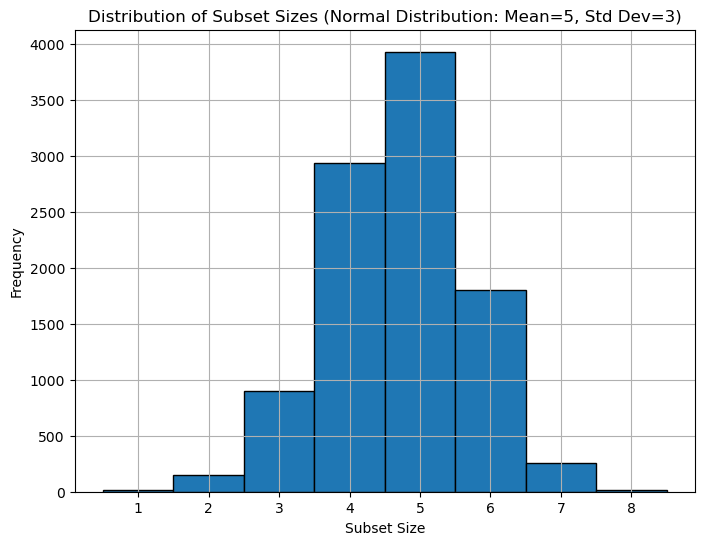

In [6]:
# Extract the sizes of the subsets
subset_sizes = [len(subset) for subset in new_combinations]

# Plot the distribution of subset sizes
plt.figure(figsize=(8, 6))
plt.hist(subset_sizes, bins=range(1, max(subset_sizes)+2), align='left', edgecolor='black')
plt.title('Distribution of Subset Sizes (Normal Distribution: Mean=5, Std Dev=3)')
plt.xlabel('Subset Size')
plt.ylabel('Frequency')
plt.xticks(range(1, max(subset_sizes)+1))
plt.grid(True)
plt.show()

# Find difference set between the new subsets and the already computed subsets

In [7]:
def convert_tuples_to_sets(tuple_list):
    # Convert each tuple in the list to a set
    set_list = [set(tup) for tup in tuple_list]
    return set_list

unique_subsets_sets = convert_tuples_to_sets(new_combinations)

In [23]:
def find_new_combinations(combinations_already_computed, new_combinations):
    # Create a new list for combinations that are in combinations_already_computed but not in unique_subsets
    result_combis = []
    counter = 0
    
    for combination in new_combinations:
        counter +=1
        if combination not in combinations_already_computed:
            result_combis.append(combination)
    
    return result_combis, counter

new_combinations, counter = find_new_combinations(combinations_already_computed = combinations_already_computed, new_combinations=unique_subsets_sets)
print("New combinations not in unique_subsets:")
print(counter)
print(len(new_combinations))

New combinations not in unique_subsets:
10000
9974


In [24]:
# Save the random_subset list to a file using pickle
with open('subset_10k_comb_new.pkl', 'wb') as file:
    pickle.dump(new_combinations, file)

In [25]:
file_path = '../../../../data/pop_1pm_simulations/pop_1pm/paris_1pm_network.xml.gz'
districts = gpd.read_file("../../../../data/visualisation/districts_paris.geojson")

base_output_links_no_policies = '../../../../data/pop_1pm_simulations/pop_1pm/output_1pm/'
base_network_no_policies = nio.read_network_data(base_output_links_no_policies)
base_network_no_policies.rename(columns={'link': 'id'}, inplace=True)

# Parse nodes and edges
nodes_dict = nio.parse_nodes(file_path)
df_edges = nio.parse_edges(file_path, nodes_dict)
gdf_edges = gpd.GeoDataFrame(df_edges, geometry='geometry', crs='EPSG:2154')
gdf_edges_4326 = gdf_edges.to_crs(epsg=4326)

# Spatial join to find districts overlapping with each edge
gdf_edges_with_districts = gpd.sjoin(gdf_edges_4326, districts, how='left', op='intersects')

# Group by edge and aggregate the district names
gdf_edges_with_districts = gdf_edges_with_districts.groupby('id').agg({
    'from': 'first',
    'to': 'first',
    'length': 'first',
    'freespeed': 'first',
    'capacity': 'first',
    'permlanes': 'first',
    'oneway': 'first',
    'modes': 'first',
    'geometry': 'first',
    'c_ar': lambda x: list(x.dropna())
}).reset_index()

# Rename the aggregated column to 'district'
gdf_edges_with_districts.rename(columns={'c_ar': 'district'}, inplace=True)

# Convert freespeed and capacity to numeric values
gdf_edges_with_districts['freespeed'] = pd.to_numeric(gdf_edges_with_districts['freespeed'], errors='coerce')
gdf_edges_with_districts['capacity'] = pd.to_numeric(gdf_edges_with_districts['capacity'], errors='coerce')

gdf_edges_with_highway = gdf_edges_with_districts.merge(base_network_no_policies[['id', 'osm:way:highway']], on='id', how='left')
gdf_edges_with_highway.head()

higher_order_roads = ['tertiary', 'secondary', 'primary', 'secondary_link', 'primary_link', 'tertiary_link']
filtered_gdf = gdf_edges_with_highway[gdf_edges_with_highway['osm:way:highway'].isin(higher_order_roads)]
filtered_gdf = gpd.GeoDataFrame(filtered_gdf, geometry='geometry', crs='EPSG:4326')
gdf_edges_with_highway = gpd.GeoDataFrame(gdf_edges_with_highway, geometry='geometry', crs='EPSG:4326')

/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/pandas/core/reshape/merge.py:1203: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


In [27]:
import os
import gc
import random
import pandas as pd
import gzip
import xml.etree.ElementTree as ET

# Directory to save the files
output_base_dir = '../../../../data/pop_1pm_simulations/pop_1pm_policies_combinations_with_normal_dist/networks/'

# Number of files per directory
files_per_dir = 100

# Function to write XML to a compressed .gz file
def write_xml_to_gz(xml_tree, file_path):
    with gzip.open(file_path, 'wb') as f:
        xml_tree.write(f, encoding='utf-8', xml_declaration=True)

# Ensure the base output directory exists
os.makedirs(output_base_dir, exist_ok=True)

# Create and save the networks
for i, combination in enumerate(new_combinations):
    if isinstance(combination, int):
        combination = (combination,)
    df_copy = gdf_edges_with_highway.copy()
    df_copy['policy_introduced'] = df_copy['district'].apply(
        lambda districts: any(d in districts for d in combination)
    ) & df_copy.apply(
        lambda row: 'car' in row['modes'] and row['osm:way:highway'] in higher_order_roads, axis=1
    )
    # Modify freespeed and capacity based on the policy_introduced condition
    df_copy.loc[df_copy['policy_introduced'], 'capacity'] = df_copy.loc[df_copy['policy_introduced'], 'capacity'] / 2

    # Determine the subdirectory based on the file index
    dir_index = (i // files_per_dir) + 1
    subdir_name = f"networks_{dir_index * files_per_dir}"
    output_dir = os.path.join(output_base_dir, subdir_name)
    
    # Create the subdirectory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Determine the filename based on the combination
    if len(combination) == 1:
        filename = f"network_d_{combination[0]}.xml.gz"
    else:
        filename = f"network_d_{'_'.join(map(str, combination))}.xml.gz"
    
    # Convert the DataFrame to XML
    xml_tree = nio.dataframe_to_xml(df_copy, nodes_dict)
    
    # Write the XML to a compressed .gz file
    file_path = os.path.join(output_dir, filename)
    nio.write_xml_to_gz(xml_tree, file_path)

    # Clear the dataframe from memory
    del df_copy
    gc.collect()

# Example: Display the file paths of the saved files
output_files = [os.path.join(root, f) for root, _, files in os.walk(output_base_dir) for f in files]
print(output_files)

['../../../../data/pop_1pm_simulations/pop_1pm_policies_combinations_with_normal_dist/networks/networks_3100/network_d_1_11_4_17.xml.gz', '../../../../data/pop_1pm_simulations/pop_1pm_policies_combinations_with_normal_dist/networks/networks_3100/network_d_8_16_18_4.xml.gz', '../../../../data/pop_1pm_simulations/pop_1pm_policies_combinations_with_normal_dist/networks/networks_3100/network_d_2_12_15_16_19.xml.gz', '../../../../data/pop_1pm_simulations/pop_1pm_policies_combinations_with_normal_dist/networks/networks_3100/network_d_4_9_12_18_20.xml.gz', '../../../../data/pop_1pm_simulations/pop_1pm_policies_combinations_with_normal_dist/networks/networks_3100/network_d_1_10_11_14_16_18.xml.gz', '../../../../data/pop_1pm_simulations/pop_1pm_policies_combinations_with_normal_dist/networks/networks_3100/network_d_2_4_7_9_13.xml.gz', '../../../../data/pop_1pm_simulations/pop_1pm_policies_combinations_with_normal_dist/networks/networks_3100/network_d_3_7_11_14_15.xml.gz', '../../../../data/pop_